# Twitter Sentiment Investing Strategy

# 1. Load Twitter Sentiment Data
* Load the twitter sentiment dataset, set the index, calculate engagement ratio and filter out stocks with no significant twitter activity

In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

In [372]:
fDirect = 'C:/Users/nurma/JupyterNotebooks/randomFiles'
sentiment_df = pd.read_csv(os.path.join(fDirect, 'sentiment_data.csv'))
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.set_index(['date', 'symbol'])
sentiment_df['egg_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']
sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>100) & (sentiment_df['twitterComments']>50)]

In [374]:
sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           BA              61.0             55.0         342.0   
           CRM             25.0           7183.0       29832.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  egg_ratio  
date       symbol                                                   
2021-11-18 AAPL             7981808.0               NaN   0.119590  
           AMD              1645270.0               NaN   0.228891  
           AMZN             5590695.0               NaN   0.101396  
           BA                425847.0               NaN   0.160819  
           CRM               142826.0               NaN   0.240782  
...                               ...               ...        ...  
2023-01-04 T                 884935.0          0.590457   0.238876  
           TSLA            55464921.0          0.543057   0.141893  
           TSN                57207.0          0.561900   0.365217  
           V                 139835.0          0.567286   0.169611  
           XOM               483389.0          0.588914   0.180589  

[21907 rows x 6 columns]

# 2. Aggregate Monthly and Calculate Average Sentiment for the Month
* Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [608]:
agg_df = ((sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='ME'), 'symbol']))[['egg_ratio']].mean())
agg_df['rank'] = (agg_df.groupby(level=0)['egg_ratio']
                  .transform(lambda x: x.rank(ascending=False)))
agg_df

egg_ratio  rank
date       symbol                 
2021-11-30 AAL      0.215625  32.0
           AAPL     0.256318  21.0
           ABBV     0.214665  34.0
           ABT      0.235784  23.0
           AES      0.864613   2.0
...                      ...   ...
2023-01-31 TMO      0.333313  18.0
           TSLA     0.151992  70.0
           TSN      0.382881  12.0
           V        0.194045  58.0
           XOM      0.217904  50.0

[1085 rows x 2 columns]

In [634]:
agg_df = ((sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='ME'), 'symbol']))[['twitterSentiment']].mean())
agg_df['rank'] = (agg_df.groupby(level=0)['twitterSentiment']
                  .transform(lambda x: x.rank(ascending=True)))
agg_df

twitterSentiment  rank
date       symbol                        
2021-11-30 AAL                  NaN   NaN
           AAPL                 NaN   NaN
           ABBV                 NaN   NaN
           ABT                  NaN   NaN
           AES                  NaN   NaN
...                             ...   ...
2023-01-31 TMO             0.559062  13.0
           TSLA            0.538939   5.0
           TSN             0.540111   6.0
           V               0.569579  24.0
           XOM             0.586793  43.0

[1085 rows x 2 columns]

# 3.Select Top 5 Stocks based on their cross-sectional ranking for each month
* Select top 5 stocks by rank for each month and fix the date to start at beginning of the next month

In [637]:
filt_df = agg_df[agg_df['rank'] < 6]
filt_df = filt_df.reset_index('symbol')
filt_df.index = filt_df.index + pd.DateOffset(1)

filt_df = filt_df.reset_index().set_index(['date', 'symbol'])
filt_df.head(20)

twitterSentiment  rank
date       symbol                        
2022-03-01 AAP             0.255316   3.0
           CB              0.214160   1.0
           HBAN            0.243020   2.0
           REGN            0.364437   5.0
           TSN             0.308430   4.0
2022-04-01 AAP             0.380083   3.0
           AES             0.374021   2.0
           EA              0.399769   4.0
           ILMN            0.306888   1.0
           TSN             0.399891   5.0
2022-05-01 AEP             0.282935   1.0
           BMY             0.361242   5.0
           CVX             0.353262   3.0
           HON             0.354038   4.0
           L               0.315707   2.0
2022-06-01 AAP             0.363108   4.0
           BKR             0.338506   3.0
           J               0.276627   2.0
           STZ             0.254878   1.0
           TMO             0.384303   5.0

# 4. Extract the stocks to form portfolios with at the start of each new month
* Create a dicitonary containing start of month and corresponded selected stocks

In [640]:
dates = filt_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filt_df.xs(d, level=0).index.tolist()

fixed_dates

{'2022-03-01': ['AAP', 'CB', 'HBAN', 'REGN', 'TSN'],
 '2022-04-01': ['AAP', 'AES', 'EA', 'ILMN', 'TSN'],
 '2022-05-01': ['AEP', 'BMY', 'CVX', 'HON', 'L'],
 '2022-06-01': ['AAP', 'BKR', 'J', 'STZ', 'TMO'],
 '2022-07-01': ['CB', 'DLTR', 'HBAN', 'ILMN', 'STZ'],
 '2022-08-01': ['AES', 'EL', 'NCLH', 'RCL', 'STZ'],
 '2022-09-01': ['AEP', 'BIIB', 'J', 'K', 'REGN'],
 '2022-10-01': ['AES', 'BIIB', 'HON', 'J', 'STZ'],
 '2022-11-01': ['AEP', 'HON', 'MA', 'NUE', 'TSN'],
 '2022-12-01': ['HON', 'K', 'REGN', 'STZ', 'TSN'],
 '2023-01-01': ['EA', 'HON', 'MA', 'STZ', 'TSN'],
 '2023-02-01': ['A', 'BIIB', 'EA', 'MNST', 'TSLA']}

# 5. Download fresh stock prices for only selected/shortlisted stocks

In [643]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

In [645]:
prices_df = yf.download(tickers=stocks_list,
                        start=pd.to_datetime(dates[0].strftime('%Y-%m-%d')) - pd.offsets.DateOffset(months=12),
                        end=pd.to_datetime(dates[-1].strftime('%Y-%m-%d')) + pd.offsets.DateOffset(months=1))

prices_df

[*********************100%%**********************]  85 of 85 completed

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Price        Adj Close                                                 \
Ticker               A        AAL         AAP        AAPL        ABBV   
Date                                                                    
2021-03-01  121.689835  21.180000  149.684235  125.284508   94.153328   
2021-03-02  120.868668  21.440001  151.690292  122.666862   93.666985   
2021-03-03  116.625938  22.170000  152.601303  119.666840   92.676895   
2021-03-04  112.412552  21.240000  152.334457  117.774689   91.756294   
2021-03-05  113.536774  20.450001  157.828201  119.039406   92.668221   
...                ...        ...         ...         ...         ...   
2023-02-22  140.565460  15.560000  139.062637  147.747742  142.166794   
2023-02-23  141.673508  15.870000  137.503723  148.233902  143.487778   
2023-02-24  139.694839  15.560000  134.444016  145.564911  144.091660   
2023-02-27  140.664383  15.630000  136.167511  146.765472  145.573044   
2023-02-28  140.456619  15.980000  140.360138  146.259445  145.214493   

Price                                                                ...  \
Ticker             ABT        AEP        AES         ALB        AMD  ...   
Date                                                                 ...   
2021-03-01  114.768402  67.362228  24.249922  148.406311  86.389999  ...   
2021-03-02  115.068916  67.133911  24.079275  149.153427  84.129997  ...   
2021-03-03  111.922905  67.019753  24.151129  142.633072  80.860001  ...   
2021-03-04  108.945930  67.836426  23.243996  137.306152  77.750000  ...   
2021-03-05  110.110420  69.285362  23.342794  139.605759  78.519997  ...   
...                ...        ...        ...         ...        ...  ...   
2023-02-22   99.620415  85.452393  24.015276  242.647400  76.610001  ...   
2023-02-23   99.484604  85.348892  24.015276  249.933228  79.750000  ...   
2023-02-24   97.457069  85.085442  23.949062  245.670044  78.089996  ...   
2023-02-27   96.787682  84.746712  23.532885  253.054306  78.769997  ...   
2023-02-28   98.679405  82.770836  23.343716  250.386124  78.580002  ...   

Price         Volume                                                 \
Ticker           RCL     REGN       SLB      STZ         T      TMO   
Date                                                                  
2021-03-01  14470200   856500  17121600   892400  58790102  1309000   
2021-03-02  19538300   759200  13582700   967900  47299370  1718700   
2021-03-03   8771600   898000  20695600   704500  75820581  2001100   
2021-03-04   6512100  1093800  21586700  1285600  80437237  2508900   
2021-03-05   9546100  1223200  26809000   942200  77737336  2749200   
...              ...      ...       ...      ...       ...      ...   
2023-02-22   2044600   415500   9181100  1092200  25308800  1705300   
2023-02-23   2066600   553300   6324500   979700  24845800  1160200   
2023-02-24   2875100   525900   8458700   702900  29138100   852600   
2023-02-27   2459700   557100   6287000   608200  22981100  1110600   
2023-02-28   3662300   622700  10634200  1136900  34154800  1188800   

Price                                               
Ticker           TSLA      TSN         V       XOM  
Date                                                
2021-03-01   81408600  1614400   6982000  36998300  
2021-03-02   71196600  1811000   6155200  30302600  
2021-03-03   90624000  2573800   6484600  35358900  
2021-03-04  197758500  4588300  10658900  52137500  
2021-03-05  268189500  3362900   7582000  51429800  
...               ...      ...       ...       ...  
2023-02-22  191828500  4217700   4621800  13973800  
2023-02-23  146360000  3403500   5533800  11289400  
2023-02-24  142228100  2439300   4414400  14351000  
2023-02-27  161028300  3922200   4255300  11710500  
2023-02-28  153144900  3556300   5385400  18107000  

[504 rows x 510 columns]

In [646]:
returns_df = np.log(prices_df['Adj Close']).diff()

# 6. Calculate portfolio returns with monthly rebalancing

In [648]:
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

    cols = fixed_dates[start_date]

    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')

    returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')

    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)


In [649]:
portfolio_df

,portfolio_return
Date,
2022-03-01,-0.023640
2022-03-02,0.027697
2022-03-03,-0.000475
2022-03-04,-0.007216
2022-03-07,-0.023656
...,...
2023-02-22,0.001485
2023-02-23,0.001199
2023-02-24,-0.014029


# 7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

In [651]:
qqq_df = yf.download(tickers='QQQ',
                  start=(portfolio_df.index.get_level_values(level=0)[0] - pd.DateOffset(days=1)).strftime('%Y-%m-%d'),
                  end=(portfolio_df.index.get_level_values(level=0)[-1] + pd.DateOffset(days=1)).strftime('%Y-%m-%d'))

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('qqq_returns')

portfolio_df = pd.concat([portfolio_df, qqq_ret], axis=1).dropna()

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,qqq_returns
Date,,
2022-03-01,-0.023640,-0.015430
2022-03-02,0.027697,0.016640
2022-03-03,-0.000475,-0.014388
2022-03-04,-0.007216,-0.014598
2022-03-07,-0.023656,-0.037578
...,...,...
2023-02-22,0.001485,0.000748
2023-02-23,0.001199,0.008696
2023-02-24,-0.014029,-0.016886


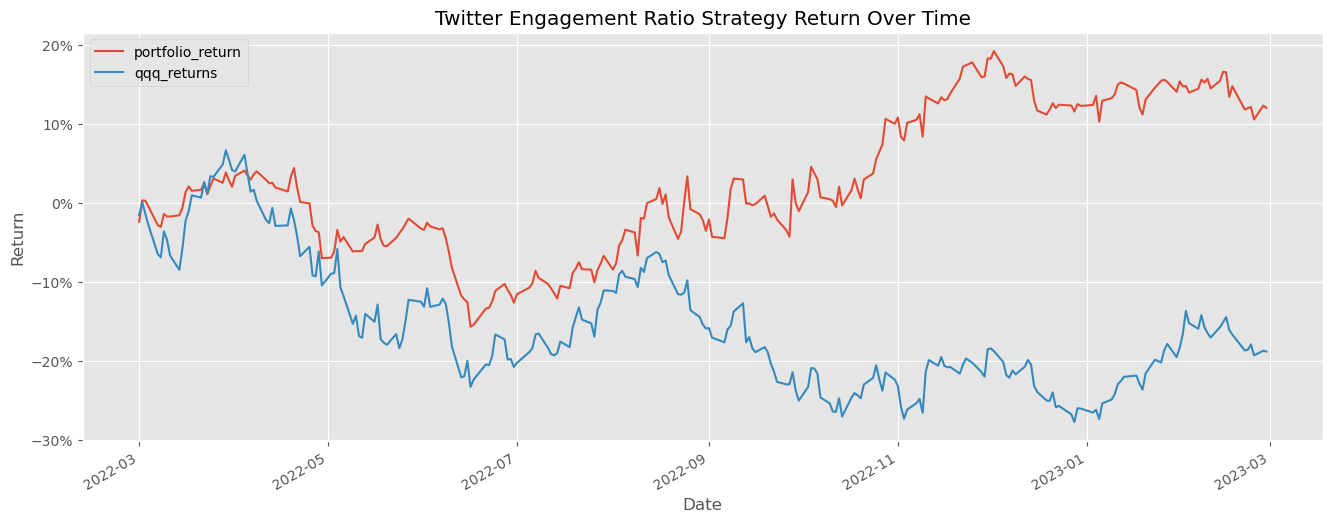

In [656]:
import matplotlib.ticker as mtick

portfolios_cumulative_return = (np.exp(np.log1p(portfolio_df).cumsum()).sub(1))

portfolios_cumulative_return.plot(figsize = (16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()



In [658]:
portfolios_cumulative_return

,portfolio_return,qqq_returns
Date,,
2022-03-01,-0.023640,-0.015430
2022-03-02,0.003402,0.000954
2022-03-03,0.002926,-0.013448
2022-03-04,-0.004311,-0.027849
2022-03-07,-0.027865,-0.064381
...,...,...
2023-02-22,0.120217,-0.185911
2023-02-23,0.121561,-0.178832
2023-02-24,0.105826,-0.192698
